In [1]:
# For running on colab
# !pip install portalocker==2.1

In [1]:
import time
from collections import Counter
from itertools import tee
from torchtext.datasets import WikiText2

import matplotlib.pyplot as plt
import pandas as pd

from logochemy import bpe_reduce, mbe_reduce

In [4]:
train_iter = WikiText2(split="train")

# case-insensitive versions (the default)
train_str = ''.join([v for v in train_iter]).lower()
train_list = list(train_str)

print(f'Total characters in the text: {len(train_str)}')
print(f'Alphabet size: {len(Counter(train_str))}')

Total characters in the text: 10780437
Alphabet size: 243


In [5]:
# One iteration of byte-pair merging

start_time = time.time()
bpe_reduce(train_list, niter=1)
print(f'time {time.time() - start_time:.3f} s')

Input tokens: 10780437, vocabulary size = 243, n(c1) = 960245, n(c2) = 2088628, n(c1, c2) = 310378.
Replacing ('e', ' ')
time 6.975 s


In [13]:
# 6 iterations of byte-pair merging with pair sording by mutual information

start_time = time.time()
train_list_bpe = train_list

for i in range(2):
    train_list_bpe = bpe_reduce(train_list_bpe, niter=3, kf="mi")
    print(f'Iteration: {i:4}. Time since start: {(time.time() - start_time)/60:.2f} min.')

Input tokens: 10780437, vocabulary size = 243, n(c1) = 700446, n(c2) = 393083, n(c1, c2) = 221132.
Replacing ('t', 'h')
Input tokens: 10559305, vocabulary size = 244, n(c1) = 105274, n(c2) =  54635, n(c1, c2) =  54625.
Replacing ('k', '>')
Input tokens: 10504680, vocabulary size = 245, n(c1) = 221132, n(c2) = 960245, n(c1, c2) = 157280.
Replacing ('th', 'e')
Iteration:    0. Time since start: 0.20 min.
Input tokens: 10347400, vocabulary size = 246, n(c1) =  54638, n(c2) = 256331, n(c1, c2) =  54625.
Replacing ('<', 'u')
Input tokens: 10292775, vocabulary size = 247, n(c1) = 2088628, n(c2) = 157280, n(c1, c2) = 146702.
Replacing (' ', 'the')
Input tokens: 10146073, vocabulary size = 248, n(c1) = 146702, n(c2) = 1941926, n(c1, c2) = 130563.
Replacing (' the', ' ')
Iteration:    1. Time since start: 0.40 min.


In [10]:
# Multibyte encoding 

_ = mbe_reduce(train_list, nmax=5, mpi=2, niter=3)

Input tokens: 10780437, f =  5.07e-03, k = 243, (n-1)*f*k*ln(k) =  27.054
Replacing [(' ', 't', 'h', 'e', ' '), ('<', 'u', 'n', 'k', '>')]
Input tokens: 10038905, f =  1.61e-02, k = 245, (n-1)*f*k*ln(k) =  21.713
Replacing [('s', ' '), ('i', 'n')]
Input tokens:  9664316, f =  1.34e-02, k = 247, (n-1)*f*k*ln(k) =  18.183
Replacing [('e', ' '), ('a', 'n')]


# Text statistics

In [6]:
def count_n(it, n):
    """Counts overlapping n-element sequences from an iterator."""
    il = tee(it, n)
    for i, iter_i in enumerate(il):
        for _ in range(i):
            next(iter_i)
    return Counter(zip(*il))

def count_n_unordered(it, n):
    """Counts overlapping n-element sequences from an iterator."""
    il = tee(it, n)
    for i, iter_i in enumerate(il):
        for _ in range(i):
            next(iter_i)
    return Counter(map(lambda x: frozenset(Counter(x).items()), zip(*il)))

## Counting the ordered combinations of characters

In [5]:
start_time = time.time()
char_cnts = [count_n(train_str, i) for i in range(1, 16)]  # sequences of 2 to 15 tokens
print(f'time {time.time() - start_time:.3f} s')

time 95.526 s


In [6]:
min_ncount = (0, 1, 10, 100, 1000)  # minimum number of counts
d = {f'>{nc} counts':[len([k for k, v in cnt.items() if v > nc]) for cnt in char_cnts] for nc in min_ncount}
cdf = pd.DataFrame(d, index=[f'{i+1}-token' for i in range(len(char_cnts))])

In [15]:
cdf

,>0 counts,>1 counts,>10 counts,>100 counts,>1000 counts
1-token,243,243,123,70,54
2-token,1628,1628,1056,736,449
3-token,13453,12713,8777,4803,1806
4-token,71913,63206,35207,12934,2142
5-token,260622,195276,81738,18334,1378
6-token,689031,431650,127881,17175,821
7-token,1396234,723418,149924,13902,475
8-token,2330206,990803,150160,10427,256
9-token,3390749,1186401,137086,7223,130
10-token,4474981,1293110,117365,4746,55


In [8]:
char_cnts[-1].most_common(10)

[((' ', '<', 'u', 'n', 'k', '>', ' ', ',', ' ', '<', 'u', 'n', 'k', '>', ' '),
  902),
 ((' ', 'u', 'n', 'i', 't', 'e', 'd', ' ', 's', 't', 'a', 't', 'e', 's', ' '),
  783),
 ((' ', '<', 'u', 'n', 'k', '>', ' ', '<', 'u', 'n', 'k', '>', ' ', ',', ' '),
  745),
 ((' ', 't', 'h', 'e', ' ', 'u', 'n', 'i', 't', 'e', 'd', ' ', 's', 't', 'a'),
  668),
 (('t', 'h', 'e', ' ', 'u', 'n', 'i', 't', 'e', 'd', ' ', 's', 't', 'a', 't'),
  668),
 (('h', 'e', ' ', 'u', 'n', 'i', 't', 'e', 'd', ' ', 's', 't', 'a', 't', 'e'),
  668),
 (('e', ' ', 'u', 'n', 'i', 't', 'e', 'd', ' ', 's', 't', 'a', 't', 'e', 's'),
  668),
 ((' ', '<', 'u', 'n', 'k', '>', ' ', 'a', 'n', 'd', ' ', '<', 'u', 'n', 'k'),
  653),
 (('<', 'u', 'n', 'k', '>', ' ', 'a', 'n', 'd', ' ', '<', 'u', 'n', 'k', '>'),
  653),
 (('u', 'n', 'k', '>', ' ', 'a', 'n', 'd', ' ', '<', 'u', 'n', 'k', '>', ' '),
  653)]

# Plotting the frequencies of ordered combinataions

In [4]:
plns = [round(2**k) for k in range(7)]
plns

[1, 2, 4, 8, 16, 32, 64]

In [5]:
# the frequency distribution of n-char sequences
start_time = time.time()
char_fds = [sorted(count_n(train_str, i).values(), reverse=True) for i in plns]
print(f'time {time.time() - start_time:.3f} s')

time 85.714 s


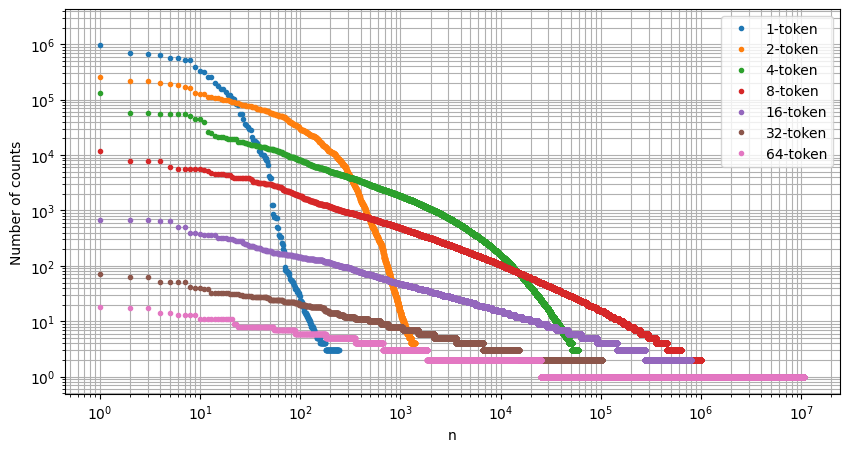

In [10]:
plt.figure(figsize=(10, 5))

for n, fd in zip(plns, char_fds):
    plt.plot(fd, marker='.', linestyle='none', label=f'{n}-token')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('Number of counts')
plt.legend()
plt.grid(which='both')

# Counting combinations of characters neglecting the order

In [ ]:
# There seems to be surprisingly little information contained in the character position

In [19]:
start_time = time.time()
char_cnts_uo = [count_n_unordered(train_str, i) for i in range(2, 10)]  # sequences of 2 to 9 tokens
print(f'time {time.time() - start_time:.3f} s')

time 360.351 s


In [20]:
min_ncount = (0, 1, 10, 100, 1000)  # minimum number of counts
d_no = {f'>{nc} counts':[len([k for k, v in cnt.items() if v > nc]) for cnt in char_cnts_uo] for nc in min_ncount}
cdf_no = pd.DataFrame(d_no, index=[f'{i+2}-token' for i in range(len(char_cnts_uo))])

In [23]:
# cdf_no.to_csv('unordered_counts.csv')
# cdf_no = pd.read_csv('unordered_counts.csv', index_col=0)

In [22]:
cdf_no

,>0 counts,>1 counts,>10 counts,>100 counts,>1000 counts
2-token,1055,1055,679,446,301
3-token,6012,5535,3822,2359,1140
4-token,24385,21650,14128,6745,2004
5-token,84882,67953,35213,12329,2239
6-token,220947,158254,67123,17594,1744
7-token,465643,301490,107143,20070,1004
8-token,871004,510891,147819,17783,530
9-token,1463241,777920,173251,13369,293


In [27]:
char_cnts_uo[-1].most_common(3)

[(frozenset({('\n', 2), (' ', 5), ('=', 2)}), 11164),
 (frozenset({(' ', 3),
             (',', 1),
             ('<', 1),
             ('>', 1),
             ('k', 1),
             ('n', 1),
             ('u', 1)}),
  10858),
 (frozenset({(' ', 2),
             ('<', 1),
             ('>', 1),
             ('f', 1),
             ('k', 1),
             ('n', 1),
             ('o', 1),
             ('u', 1)}),
  8981)]

In [31]:
# The difference in the number of ordered and unordered unique combinations
cdf[1:9] - cdf_no

,>0 counts,>1 counts,>10 counts,>100 counts,>1000 counts
2-token,573,573,377,290,148
3-token,7441,7178,4955,2444,666
4-token,47528,41556,21079,6189,138
5-token,175740,127323,46525,6005,-861
6-token,468084,273396,60758,-419,-923
7-token,930591,421928,42781,-6168,-529
8-token,1459202,479912,2341,-7356,-274
9-token,1927508,408481,-36165,-6146,-163


In [34]:
# The fractional difference
((cdf[1:9] - cdf_no)/cdf[1:9])

,>0 counts,>1 counts,>10 counts,>100 counts,>1000 counts
2-token,0.351966,0.351966,0.357008,0.394022,0.329621
3-token,0.553111,0.564619,0.564544,0.508849,0.368771
4-token,0.660910,0.657469,0.598716,0.478506,0.064426
5-token,0.674310,0.652016,0.569197,0.327534,-0.624819
6-token,0.679337,0.633374,0.475114,-0.024396,-1.124239
7-token,0.666501,0.583242,0.285351,-0.443677,-1.113684
8-token,0.626212,0.484367,0.015590,-0.705476,-1.070312
9-token,0.568461,0.344303,-0.263812,-0.850893,-1.253846


# Paragraphs and sections

In [17]:
import re
# The sections are denoted as  = ... = (1-st order), == ... == (2-nd order) or === ... === (3-rd order)b

In [41]:
# Training data

nh1 = len(re.findall('\n = [^=\n]+ = \n', train_str))
nh2 = len(re.findall('\n = = [^=\n]+ = = \n', train_str))
nh3 = len(re.findall('\n = = = [^=\n]+ = = = \n', train_str))

print(f"1-st order headers: {nh1}")
print(f"2-nd order headers: {nh2}")
print(f"3-rd order headers: {nh3}")

1-st order headers: 629
2-nd order headers: 2922
3-rd order headers: 2346


In [42]:
# Validation data

nh1 = len(re.findall('\n = [^=\n]+ = \n', val_str))
nh2 = len(re.findall('\n = = [^=\n]+ = = \n', val_str))
nh3 = len(re.findall('\n = = = [^=\n]+ = = = \n', val_str))

print(f"1-st order headers: {nh1}")
print(f"2-nd order headers: {nh2}")
print(f"3-rd order headers: {nh3}")

1-st order headers: 60
2-nd order headers: 301
3-rd order headers: 237


# Plain words

In [ ]:
train_word_list = train_str.split()
word_cnt = Counter(train_word_list)
print(f'Total words in the text: {len(train_word_list)}')
print(f'Vocabulary size: {len(word_cnt)}')

Total words in the text: 2051910
Vocabulary size: 28911


In [ ]:
# Mean word length
sum(len(k) * word_cnt[k]  for k in word_cnt)/len(train_word_list)

4.2180656071660065

In [ ]:
print(word_cnt.most_common(20))

[('the', 130768), (',', 99913), ('.', 73388), ('of', 57030), ('<unk>', 54625), ('and', 50735), ('in', 44982), ('to', 39521), ('a', 36156), ('=', 29570), ('"', 28309), ('was', 21008), ('@-@', 16906), ('on', 15140), ('as', 15058), ('that', 14351), ("'s", 14002), ('for', 13794), ('with', 13012), ('by', 12718)]


In [ ]:
print(word_cnt.most_common()[-20:])

[('yellowwoods', 3), ('tomentum', 3), ('secretion', 3), ('spruces', 3), ('lewenthal', 3), ('caprices', 3), ('étude', 3), ('mineurs', 3), ('sonatine', 3), ('chants', 3), ('philipp', 3), ('prefaced', 3), ('kreutzer', 3), ('forrester', 3), ('zoromski', 3), ('roundabouts', 3), ('tuscola', 3), ('northeasterly', 3), ('intergrades', 3), ('gallinae', 3)]
